# Projeto 3 -  Clusterização

## Informações do Projeto
DataSet:<br /><br />https://www.kaggle.com/new-york-city/nyc-property-sales
     nyc-property-sales

Grupo:
      Antonio Andraues<br />
      Lucca Delchiaro <br/ >
      Joao Edvirges.<br /><br />


In [5]:
import math
import pandas as pd
import json
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import numpy as np
from sklearn.mixture import GMM
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt

In [6]:
dados=pd.read_csv("nyc-rolling-sales.csv")
dados


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
5,9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,,C4,516 EAST 12TH STREET,...,20,0,20,2581,9730,1900,2,C4,-,2017-07-20 00:00:00
6,10,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,...,8,0,8,1750,4226,1920,2,C4,3192840,2016-09-23 00:00:00
7,11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,,C7,520 EAST 14TH STREET,...,44,2,46,5163,21007,1900,2,C7,-,2017-07-20 00:00:00
8,12,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,,D5,141 AVENUE D,...,15,0,15,1534,9198,1920,2,D5,-,2017-06-20 00:00:00
9,13,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,...,24,0,24,4489,18523,1920,2,D9,16232000,2016-11-07 00:00:00


    A partir do dataset escolhido, a equipe percebeu que há questões de sensibilidades em relação aos algoritmos disponíveis. Partindo do princípio de que o dataset está possui informações de boa qualidade, achou-se melhor optar dentre DBSCAN, K-Means e Mean Shift, o algoritmo Mean Shift por ter mais afinidade as nossas váriaveis.(doc:http://scikit-learn.org/stable/modules/clustering.html). Numa rápida lida no data base, viu-se a necessidade de definir quais regiões possuem high budget e low budget. Para isso, um elemento necessário e identificar para qual centróide cada ponto está convergindo, dando uma idéia de agrupamento e assim definindo cada bairro com sua income.Porém para esse cluster ficar apresentável, sabe-se que um processo de smoothing será necessário, pois mesmo dentro de divisões via renda, ainda assim dentro de uma classe, possui-se diferenças grandes nas rendas e nas depesas.Por isso a escolha do mean shift, que vai pegar cada ponto convergindo e dar uma suavizada nesse resultados, mostrando mais definido cada região.(Doc:https://www.youtube.com/watch?v=yTsslXB5v1s,https://www.youtube.com/watch?v=yhz8Fm0ymm8)
   O mean shift e utilizado em suavização de pixels, diminuindo as diferenças que cada cor possui, tornando a imagem de saída menos discrepante. 
   
   Segue o exemplo de um cluster via Mean Shift:
  http://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html
  
  A biblioteca que a equipe vai importar e a própria do scikit learn.

In [69]:
dados2=dados.loc[:,['NEIGHBORHOOD','SALE PRICE','BLOCK','TAX CLASS AT PRESENT','LAND SQUARE FEET']] #selecionando os subsets que vamos trabalhar
dados2=dados2.rename(columns={'SALE PRICE': 'SALE_PRICE'})#facilitar a representacao da coluna
dados2=dados2.rename(columns={'TAX CLASS AT PRESENT': 'TAX_CLASS_AT_PRESENT'})
dados2=dados2.rename(columns={'LAND SQUARE FEET': 'LAND_SQUARE_FEET'})
dados2.SALE_PRICE[2] #Formato do preco nao completado
dados2=dados2.loc[dados2.SALE_PRICE!=' -  ']
dados2=dados2.loc[dados2.LAND_SQUARE_FEET!=' -  ']#retirada do formato "Nao completado"
dados2.SALE_PRICE=dados2.SALE_PRICE.astype("float")
dados2.LAND_SQUARE_FEET=dados2.LAND_SQUARE_FEET.astype("float")
dados2=dados2.loc[dados2.TAX_CLASS_AT_PRESENT!='3'] #retirando fabricas e terrenos
dados2=dados2.loc[dados2.TAX_CLASS_AT_PRESENT!='4']
dados2.SALE_PRICE=dados2.SALE_PRICE/dados2.LAND_SQUARE_FEET  #preco por metro quadrado
dados2.SALE_PRICE=dados2.SALE_PRICE.loc[dados2.SALE_PRICE>=1]#filtrando casa abaixo do valor de 10milhoes de dollares
dados2.SALE_PRICE=dados2.SALE_PRICE.loc[dados2.SALE_PRICE<=10000]
dados2=dados2.dropna()

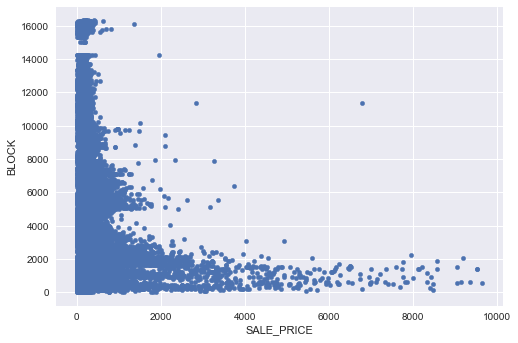

In [70]:
n=3 #numeros de bairros
bairros = dados2.NEIGHBORHOOD[~dados2.NEIGHBORHOOD.duplicated(keep='first')] #Nomes de todos os bairros uma unica vez
primeirosB=bairros[:n] #primeiros 10 bairros para analize
primeirosBairros=[] #colocando os nomes em uma lista
for i in primeirosB:
    primeirosBairros.append(i)
        
Precos=[]         #pegando os precos para cada bairro
for u in primeirosBairros:  
    ppp=dados2.loc[dados2.NEIGHBORHOOD==u]
    pp=ppp  #Serve para analizar cada bairro individualmente
    for c in range(0,len(ppp)):
        preco=ppp.SALE_PRICE
    Precos.append(preco)
dados2.plot.scatter(x='SALE_PRICE',y='BLOCK',norm=1)

dd=pd.DataFrame(Precos,columns=[primeirosBairros]) #Gerado randomicamente so para teste    

# Plot
# fig, ax = plt.subplots()
# ax.legend()

# plt.show()

# dd=pd.DataFrame(np.random.rand(len(preco), n),columns=[primeirosBairros]) #Gerado randomicamente so para teste
# print(dd.max())

# ax = dd.plot.scatter(x=primeirosBairros[0], y=primeirosBairros[0], color='DarkBlue', label=primeirosBairros[0]);
# dd.plot.scatter(x=primeirosBairros[1], y=primeirosBairros[1], color='DarkGreen', label=primeirosBairros[1], ax=ax);

# plt.show()



In [91]:
# for i in bairros:
(dados2["NEIGHBORHOOD"]=="ALPHABET CITY").

KeyError: 'Level True must be same as name (None)'

In [ ]:
# N = 5 #ESQUECER ESSA PARTE (SO TESTES)
# arr = np.arange(N*2).reshape(N,2)
# words=np.array(primeirosBairros)
# df = pd.DataFrame(words[arr % 10], columns=list('XY'))
# df['Z'] = dados2.SALE_PRICE
# Xuniques, X = np.unique(df['X'], return_inverse=True)
# Yuniques, Y = np.unique(df['Y'], return_inverse=True)

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.scatter(X, Y, Z, s=20, c='b')
# ax.set(xticks=range(len(Xuniques)), xticklabels=Xuniques,
#        yticks=range(len(Yuniques)), yticklabels=Yuniques) 
# plt.show()

In [ ]:
headers = pp #serve para analizar cada bairro individualmente depende do n
headers.head()


In [ ]:
headers.head(5)

In [ ]:
headers.plot.scatter(x="SALE_PRICE",y="BLOCK")

In [ ]:
#E ISSO

#Ta dando problema com o sale price......

headers.plot.scatter(x="BLOCK",y="SALE_PRICE")

In [ ]:
from sklearn.mixture import GMM
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
#usando make blobs com numero de amostras = 200
data,y_true=make_blobs(n_samples=200,centers=3)
plt.scatter(data[:,0],data[:,1])
plt.show()

In [ ]:
#montando fit do gmm
gmm= GMM(n_components=3).fit(data)

#predict e um parametro de entrada do GMM 
labels=gmm.predict(data)

#bic e um parametro com filtro 
data_bic=gmm.bic(data)
#falta montar o bic + outros parametros
#definir quantos componentes e covariancia
#montar def para as elipses ou circulos

In [ ]:
#tratando o training set multiplo em um set final
#data_final = np.vstack([bairro1, bairro2..])
#predict_proba calcula a probabilidade de cada componente 
componente= gmm.predict_proba(data)
componente